In [1]:
import sys
print(sys.executable)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re
import warnings

c:\Users\User\AppData\Local\pypoetry\Cache\virtualenvs\credit-card-fraud-detection-model-FZHIqfLr-py3.13\Scripts\python.exe


<div style="background-color:#ddecfc; color:#100; padding:30px; border-radius:50px; max-width:1200px; margin:left;">

# Data Exploration – Dataset Tables

In this section we will first try to explore our raw dataset files to understand 
its structure, columns, datatypes, and potential issues (missing values, duplicates, etc.), before we preform any merge.

<br><u> We have 2 tables: </u></br>
* **customers.csv**
* **credit_card_fraud.csv**

</div>

### <font color = navy > <u> Data load: </u></font>

In [ ]:
transactions_df = pd.read_csv("C:/Users/User/Documents/GitHub/Credit_Card_Fraud_Detection_Model/data/credit_card_fraud.csv", index_col=0) #first column is index
customers_df = pd.read_csv("C:/Users/User/Documents/GitHub/Credit_Card_Fraud_Detection_Model/data/customers.csv", sep="|")

In [ ]:
print(transactions_df.shape)
print(customers_df.shape)

<div style="background-color:#f4f9fe ; color:#200; padding:30px; border-radius:50px;max-width:1200px; margin:left;">

The transaction_df has 34 million rows. Initial loading of both tables took about 6-12 minutes. <br>
To ensure smoother experimentation and reproducibility:
- lets store the datasets as Pickle (.pkl) files for quick pull (incase of kernel resets)
</br>

</div>

In [ ]:
# Save once (binary format)
transactions_df.to_pickle("transactions.pkl")
customers_df.to_pickle("customers.pkl")
warnings.filterwarnings('ignore')


In [2]:
#Quick load :
transactions_df = pd.read_pickle("transactions.pkl")
customers_df = pd.read_pickle("customers.pkl")

#### <font color='Navy'> <b><u> Functions : </b></u>

In [3]:
def compare_columns(df1, name1, df2, name2):
    """
    Compares columns between two DataFrames.
    Prints:
    1. Common columns and their data types in both datasets.
    2. Columns unique to each dataset.
    """
    set1, set2 = set(df1.columns), set(df2.columns)
    common = set1.intersection(set2)
    only_in_1 = set1 - set2
    only_in_2 = set2 - set1
    
    print("="*60)
    print("🔹 Common Columns with Data Types")
    if common:
        comparison = {
            "Column": [],
            f"{name1} dtype": [],
            f"{name2} dtype": []
        }
        for col in sorted(common):
            comparison["Column"].append(col)
            comparison[f"{name1} dtype"].append(df1[col].dtype)
            comparison[f"{name2} dtype"].append(df2[col].dtype)
        result = pd.DataFrame(comparison)
        print(result.to_string(index=False))
    else:
        print("No common columns found.")

    print("\n" + "="*60)
    print(f"🔹 Columns only in {name1}:")
    if only_in_1:
        print(sorted(list(only_in_1)))

    else:
        print("No unique columns found.")
    
    print("\n" + "="*60)
    print(f"🔹 Columns only in {name2}:")
    if only_in_2:
        print(sorted(list(only_in_2)))
    else:
        print("No unique columns found.")
    print("="*60)

    return common, only_in_1, only_in_2


In [4]:
def unique_values_report(df, name, max_rows=20):
    """
    Prints number of unique values for each column in a DataFrame.
    Shows top 'max_rows' columns sorted by uniqueness.
    """
    uniques = df.nunique().sort_values(ascending=False).reset_index()
    uniques.columns = ["Column", "Unique Values"]
    
    print(f"\n🔹 Unique Value Report for {name} (showing top {max_rows}):")
    print(uniques.head(max_rows).to_string(index=False))
    


In [5]:
def clean_punc(col):
    return (
        col.str.lower()  # lowercase
           .str.replace(r"[^a-z0-9\s]", "", regex=True)  # remove special chars
           .str.strip()  # remove leading/trailing spaces
    )



In [6]:
def column_summary(df):
    summary = pd.DataFrame({
        'count': df.shape[0],
        'nulls': df.isnull().sum(),
        'nulls%': df.isnull().mean() * 100,
        'cardinality': df.nunique(),
        'dtype': df.dtypes
    })
    return summary


In [7]:
def check_case_duplicates(df, column):
    """
    Checks if a column has values that differ only by letter case.
    Returns True if normalization (lower/upper) is recommended.
    """
    original_unique = set(df[column].dropna().unique())
    normalized_unique = set(df[column].dropna().str.lower().unique())
    
    # If sizes differ → case duplicates exist
    if len(original_unique) != len(normalized_unique):
        print(f"⚠️ Column '{column}' has case duplicates.")
        diff = len(original_unique) - len(normalized_unique)
        print(f"   → {diff} duplicate categories caused by case.")
        return True
    else:
        print(f"✅ Column '{column}' has no case duplicates.")
        return False


In [8]:
def check_column_specials(df, column, sample_size=50000, sample=5):
    """
    Checks one column for punctuation or special characters.
    Uses a sample for speed on large datasets.
    
    Parameters:
    - df: pandas DataFrame
    - column: column name (string)
    - sample_size: number of rows to sample
    - sample: number of example values to display if issues are found
    """
    # Take a sample for speed
    df_sample = df[column].dropna().sample(
        min(sample_size, df[column].dropna().shape[0]), random_state=42
    ).astype(str)
    
    pattern = re.compile(r"[^a-zA-Z0-9\s]")
    mask = df_sample.str.contains(pattern, na=False)
    count = mask.sum()
    
    if count > 0:
        print(f"⚠️ Column '{column}' has {count} rows with special characters (in sample).")
        print("   Examples:", df_sample[mask].unique()[:sample])
        return "Needs Cleaning"
    else:
        print(f"✅ Column '{column}' is clean (no special characters in sample).")
        return "Clean"


In [9]:
def add_remark(summary_table, col_name, remark):
    """
    Add a remark for a specific column in the summary_table.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
        col_name (str): Column name to mark.
        remark (str): Remark text to add.
    """
    summary_table.loc[summary_table.index == col_name, "remark"] = remark
    display(summary_table.sort_values("cardinality", ascending=False))


def status_check(summary_table):
    """
    Display all columns in summary_table that have no remark.
    Works for both empty strings and NaN values.
    
    Parameters:
        summary_table (pd.DataFrame): The summary table with 'remark' column.
    """
    unmarked = summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")]
    display(unmarked.sort_values("cardinality", ascending=False))


<div style="background-color:#ddecfc ;  color:#200; padding:30px; border-radius:50px;">

### 1️⃣ <u><b> Evaluate Data Structure </b></u>

**Objective:** Understand the composition and potential issues in both datasets.

**Actions:**
- Review **shape**, **columns**, and **sample records** to understand structure.
- Use `.info()` and `.describe()` to inspect data types and summary statistics.
- Check for:
  - **Name match** 
  - **Data type match**  
  - **Value overlap**  
  - **Uniqueness**  
  - **Nulls**  
  - **Duplicates**  

</div>

In [10]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34636378 entries, 0 to 34636377
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   int64  
 20  category    object 
 21  amt         float64
 22  is_fraud    int64  
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(5), int64(6), object(15)
memory usage: 7.0+ GB


In [11]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ssn       20000 non-null  object 
 1   cc_num    20000 non-null  int64  
 2   first     20000 non-null  object 
 3   last      20000 non-null  object 
 4   gender    20000 non-null  object 
 5   street    20000 non-null  object 
 6   city      20000 non-null  object 
 7   state     20000 non-null  object 
 8   zip       20000 non-null  int64  
 9   lat       20000 non-null  float64
 10  long      20000 non-null  float64
 11  city_pop  20000 non-null  int64  
 12  job       20000 non-null  object 
 13  dob       20000 non-null  object 
 14  acct_num  20000 non-null  int64  
 15  profile   20000 non-null  object 
dtypes: float64(2), int64(4), object(10)
memory usage: 2.4+ MB


<div style="background-color:#f4f9fe; color:#100; padding:20px; border-radius:10px;">
<font color='Navy'>

It seems that we have some type of an overlap between the two sets.
<br>
<h3><u> Pre-Merge Checks : </u></h3>
1. Col name match <br>
2. Data type match<br>
3. Uniqueness<br>
4. Value overlap<br>
5. Nulls<br>
6. Duplicates  <br>


</div>

#### <font color='Navy'>🔹Columns & Data types match check :

In [12]:
# Column Comparison - Name and Data Types:
common_cols, only_in_transactions, only_in_customers = compare_columns(
    transactions_df, "transactions", customers_df, "customers"
)

#Common columns:
print("Common columns:", common_cols) 

# Nulls check on common columns  - do we need the merge ? is the key column complete ?
print("Null counts in transactions:")
print(transactions_df[list(common_cols)].isna().sum())

print("Null counts in customers:")
print(customers_df[list(common_cols)].isna().sum())



🔹 Common Columns with Data Types
  Column transactions dtype customers dtype
acct_num              int64           int64
  cc_num              int64           int64
    city             object          object
city_pop              int64           int64
     dob             object          object
   first             object          object
  gender             object          object
     job             object          object
    last             object          object
     lat            float64         float64
    long            float64         float64
 profile             object          object
     ssn             object          object
   state             object          object
  street             object          object
     zip              int64           int64

🔹 Columns only in transactions:
['amt', 'category', 'is_fraud', 'merch_lat', 'merch_long', 'merchant', 'trans_date', 'trans_num', 'trans_time', 'unix_time']

🔹 Columns only in customers:
No unique columns found.
Common

<div style="background-color:#f4f9fe; color:#100; padding:20px; border-radius:10px;">
<font color='Navy'>
<u> Summary of comparision: </u> <br>
</br>
🔹No Nulls in both data sets ✅ <br> 
🔹16 Common features : - with matching names  ✅ -  matching Dtypes  ✅

</br>
🔹 <b> Columns only in transactions: </b> <br>
- ['amt', 'category', 'is_fraud', 'merch_lat', 'merch_long', 'merchant', 'trans_date', 'trans_num', 'trans_time', 'unix_time']
</br>

============================================================
<br>
🔹 <b> Columns only in customers </b> - <font color='red'> No unique columns found.</font>

</br>
</font>

<code>customers.csv</code> has not unique columns of its own to contribute the transaction set.<br>
At this point, merging seems pointless.<br>
</br>
but before we fully dismiss it, lets see if there is any mismatch between the common values.
lets check value overlap using the cc_num

</div>


In [13]:
'''Lets confirm that each cc_num in customers_df appears only once (one row per customer), before we check if we have full match with transaction df.'''

# Count duplicate customer IDs
dup_customers = customers_df['cc_num'].duplicated().sum()

print("Total customers:", customers_df.shape[0])
print("Unique customer IDs:", customers_df['cc_num'].nunique())
print("Duplicate customer IDs:", dup_customers)

# If there are duplicates, show a few
if dup_customers > 0:
    display(customers_df[customers_df['cc_num'].duplicated(keep=False)].head())


Total customers: 20000
Unique customer IDs: 20000
Duplicate customer IDs: 0


#### <font color='Navy'> 🔹 Value overlap :

In [14]:
trans_cards = set(transactions_df['cc_num'])
cust_cards = set(customers_df['cc_num'])

overlap = trans_cards.intersection(cust_cards)

print("Unique cc_num in transactions:", len(trans_cards))
print("Unique cc_num in customers   :", len(cust_cards))
print("Overlapping cc_num           :", len(overlap))
print("Overlap coverage in transactions: {:.2f}%".format(len(overlap) / len(trans_cards) * 100))
print("Overlap coverage in customers   : {:.2f}%".format(len(overlap) / len(cust_cards) * 100))


Unique cc_num in transactions: 19948
Unique cc_num in customers   : 20000
Overlapping cc_num           : 19948
Overlap coverage in transactions: 100.00%
Overlap coverage in customers   : 99.74%


<font color='Navy'> all unique cc_nums are included in transactions dataset. Merging will only cause duplicates. </font>

#### <font color='Navy'> 🔹 Duplicate Rows:

In [15]:
print("Duplicate rows in transactions:", transactions_df.duplicated().sum())
# print("Duplicate rows in customers   :", customers_df.duplicated().sum())


Duplicate rows in transactions: 0


#### <font color='Navy'> 🔹 Nulls:

In [16]:
print("Nulls in transactions_df :", transactions_df.isna().sum().sum())
# print("Nulls in customers cc_num   :", customers_df['cc_num'].isna().sum())


Nulls in transactions_df : 0


<div style="background-color:#f4f9fe; color:#100; padding:20px; border-radius:10px;">
<font color='Navy'>
<u> Pre-Merge Checks Summary: </u> <br>
</br>

1. Common Col Names & Dtypes - match ✅
2. Unique features - only in transaction_df, customers features ovelap fully. 📍
3. Value overlap - customers_df values incompassed by transaction_df. additional few customers included with no match.📍
5. Nulls - no nulls in both sets - ✅
5. Duplicates - no duplicate records found in both sets. ✅

</div>

Since there is no additional information given by the customer.csv, we will be working on the credict_cart_fraud.csv


In [17]:
df = transactions_df.copy()

<div style="background-color:#ddecfc ;  color:#200; padding:30px; border-radius:50px;">

### 2️⃣ Convert and Correct Data Types

**Objective:** Ensure each column is stored in the appropriate format.

**Actions:**
- Data type Corrections
- Map Object Dtypes :
    - tex
- Convert date/time fields to `datetime` (`pd.to_datetime()`).
- Convert textual categorical fields to `category` dtype.
- Drop or isolate identifiers that are unique per record.

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34636378 entries, 0 to 34636377
Data columns (total 26 columns):
 #   Column      Dtype  
---  ------      -----  
 0   ssn         object 
 1   cc_num      int64  
 2   first       object 
 3   last        object 
 4   gender      object 
 5   street      object 
 6   city        object 
 7   state       object 
 8   zip         int64  
 9   lat         float64
 10  long        float64
 11  city_pop    int64  
 12  job         object 
 13  dob         object 
 14  acct_num    int64  
 15  profile     object 
 16  trans_num   object 
 17  trans_date  object 
 18  trans_time  object 
 19  unix_time   int64  
 20  category    object 
 21  amt         float64
 22  is_fraud    int64  
 23  merchant    object 
 24  merch_lat   float64
 25  merch_long  float64
dtypes: float64(5), int64(6), object(15)
memory usage: 7.0+ GB


#### <font color='Navy'> 🔹Value Count </font>
- Drop features with 1 unique values , if exist.

In [19]:
unique_counts = df.nunique().sort_values()
print(unique_counts)


gender               2
is_fraud             2
profile             12
category            14
state               51
job                639
first              686
merchant           693
trans_date         731
last              1000
city              5184
city_pop          6236
lat               9860
long             10069
zip              10218
dob              13861
acct_num         19948
cc_num           19948
ssn              19948
street           19948
trans_time       86400
amt             174288
merch_lat     15942663
unix_time     21837719
merch_long    23233358
trans_num     34636378
dtype: int64


#### <font color='Navy'> 🔹Data type Correction - Date type

In [20]:
df['trans_date'] = pd.to_datetime(df['trans_date'], errors='coerce')
df['trans_time'] = pd.to_datetime(df['trans_time'], format='%H:%M:%S', errors='coerce')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
# customers_df['dob'] = pd.to_datetime(customers_df['dob'], errors='coerce')


In [21]:
min_date, max_date = df['trans_date'].min(), df['trans_date'].max()
# Print the results
print(f"Min Date: {min_date}") 
print(f"Max Date: {max_date}")

Min Date: 2019-01-01 00:00:00
Max Date: 2020-12-31 00:00:00


In [22]:
df['trans_year'] = df['trans_date'].dt.year
df['trans_month'] = df['trans_date'].dt.month

In [23]:
df_temp = df.copy()

In [24]:
monthly_fraud_counts = df_temp.groupby(['trans_year', 'trans_month', 'is_fraud']).size()

In [25]:
display(monthly_fraud_counts.head(3))

trans_year  trans_month  is_fraud
2019        1            0           961918
                         1             8248
            2            0           887654
dtype: int64

In [26]:
result = monthly_fraud_counts.unstack(fill_value=0)
result.columns = ['Non-Fraud', 'Fraud']
display (result.head(3))

Non-Fraud  Fraud
trans_year trans_month                  
2019       1               961918   8248
           2               887654   7207
           3              1353168   8086

In [27]:
result['Total'] = result['Non-Fraud'] + result['Fraud']
result['Fraud Percentage'] = (result['Fraud'] / result['Total']) * 100
display(result.head(3))

Non-Fraud  Fraud    Total  Fraud Percentage
trans_year trans_month                                             
2019       1               961918   8248   970166          0.850164
           2               887654   7207   894861          0.805376
           3              1353168   8086  1361254          0.594011

<Figure size 1000x600 with 0 Axes>

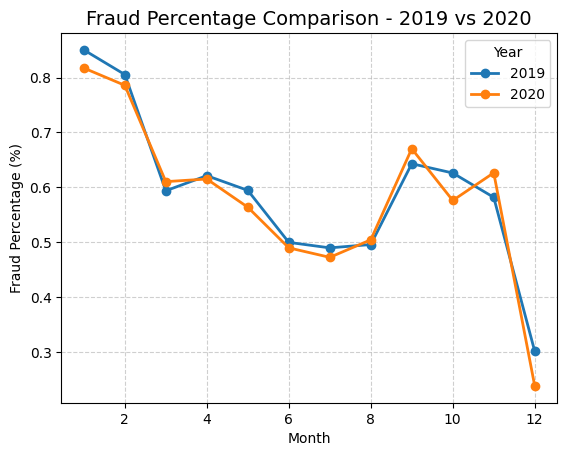

In [28]:
# Pivot to have Month as index and Year as columns
result = result.reset_index()
pivot_data = result.pivot(index='trans_month', columns='trans_year', values='Fraud Percentage')

# Plot
plt.figure(figsize=(10, 6))
pivot_data.plot(marker='o', linewidth=2)
plt.title('Fraud Percentage Comparison - 2019 vs 2020', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Fraud Percentage (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Year')
plt.show()

# Data Reduction :
- Fraud presentage and pattern seems consistent per month for 2019 and 2020.
- To improve computetional efficieny,  we can focus on 2020 data only for further exploration and model training

In [29]:
# Reduced Data Set:
df_2020 = df[df['trans_year'] == 2020].copy()

In [30]:
df_2020.to_pickle("transactions_2020.pkl")

In [31]:
df_2020 = pd.read_pickle("transactions_2020.pkl")

In [32]:
df_2020.shape

(17292422, 28)

#### <font color='Navy'> 🔹Date Dtypes :

In [33]:
# --- Extract date features ---
df_2020['trans_year'] = df_2020['trans_date'].dt.year
df_2020['trans_quarter'] = df_2020['trans_date'].dt.quarter
df_2020['trans_month'] = df_2020['trans_date'].dt.month
df_2020['trans_day'] = df_2020['trans_date'].dt.day
df_2020['trans_dayofweek'] = df_2020['trans_date'].dt.dayofweek
df_2020['trans_hour'] = df_2020['trans_time'].dt.hour

# --- Derive age ---
# --- age of the customer at the time of transaction:
df_2020['age'] = (df_2020['trans_date'] - df_2020['dob']).dt.days // 365

#### <font color='red'> 🔹Data Drop List Container Definition:

- Removal of original features that already split to columns like dates ( month, year, hour)


In [34]:
# Initialize a list to track columns to drop later
cols_to_drop = []

# Example: when you identify columns to drop, append them instead of removing now
# cols_to_drop.append('trans_time')
# cols_to_drop.append('dob')


#### <font color='Navy'> 🔹Handle Object Data Types:

- textual data convert to string
- remove special keys
- Classify to category 

In [35]:
object_cols = df_2020.select_dtypes(include=['object']).copy()
non_object_cols = df_2020.select_dtypes(exclude=['object']).copy()



In [36]:
object_cols.head(4)

,ssn,first,last,gender,street,city,state,job,profile,trans_num,category,merchant
0,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,52226c099d060def61a7e0d3de214e4b,misc_net,"fraud_Moore, Dibbert and Koepp"
1,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,6495d95c66d7d504d7352f2b8c105d3c,misc_net,fraud_Dach-Nader
2,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,bc0bfcd9e0132b171e538192b0e27777,grocery_pos,fraud_Pacocha-O'Reilly
3,750-09-7342,Amanda,Morris,F,144 Bowers Route,Tracy,CA,Teaching laboratory technician,young_adults_female_urban.json,483c446c7b56a11f0d4538056eb79984,gas_transport,"fraud_Kutch, Hermiston and Farrell"


In [37]:
summary_table = column_summary(object_cols)
display(summary_table.sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype
trans_num,17292422,0,0.0,17292422,object
ssn,17292422,0,0.0,18653,object
street,17292422,0,0.0,18653,object
city,17292422,0,0.0,5034,object
last,17292422,0,0.0,1000,object
merchant,17292422,0,0.0,693,object
first,17292422,0,0.0,686,object
job,17292422,0,0.0,639,object
state,17292422,0,0.0,51,object
category,17292422,0,0.0,14,object


- `trans_num` has high cardinality and all are unique identifiers (not really useful)
- `ssn` is unique identifier for the customers, no point removing '-', we might use it for group by.
- `street`,`city`,`state` - check for granularity and category reduction.
- `last` & `first` - consider removing.
- `job` - reduce categories.
- `category` - ?? keep
- `metchant` - clean text

In [38]:
cols_to_drop = ["ssn", "first", "last", "street", "trans_num"]
#ssn - semsitive, no predictive power, unique per person
#first, last - no predictive power
#street - high cardinality, no predictive power
#trans_num - unique per transaction, no predictive power
summary_table.loc[summary_table.index.isin(cols_to_drop), "remark"] = "Remove"
display(summary_table.sort_values("cardinality", ascending=False))


,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [39]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN
profile,17292422,0,0.0,12,object,NaN
gender,17292422,0,0.0,2,object,NaN


#### <font color='Navy'> 🔹Gender - Dtype correction and Encoding
- Classify original column from obj --> category for EDA
- Create an already Encoded column
- Add original to removable columns list


In [40]:
df_2020['gender'].value_counts()

gender
F    8949900
M    8342522
Name: count, dtype: int64

In [41]:
# Clean and encode gender
df_2020['gender'] = df_2020['gender'].str.strip().str.upper()  # just to be safe
df_2020['gender'] = df_2020['gender'].astype('category')

# Create encoded numeric column
df_2020['gender_encoded'] = df_2020['gender'].map({'F': 0, 'M': 1}).astype('int8')

# Optional: verify
print(df_2020['gender'].dtype)
print(df_2020['gender_encoded'].dtype)


category
int8


In [42]:
add_remark(summary_table, "gender", "Cetogorized and Encoded in new Column")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [43]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN
profile,17292422,0,0.0,12,object,NaN


#### <font color='Navy'> 🔹Profile:
- Inspection
- Calssify as category
- Seperate into columns - 'age group', 'gender', 'location'


In [44]:
df_2020['profile'].head(5)


0    young_adults_female_urban.json
1    young_adults_female_urban.json
2    young_adults_female_urban.json
3    young_adults_female_urban.json
4    young_adults_female_urban.json
Name: profile, dtype: object

In [45]:
df_2020['gender'] = df_2020['gender'].str.strip().str.lower()  # just to be safe
df_2020['gender'] = df_2020['gender'].astype('category')

In [46]:
df_2020['profile'] = df_2020['profile'].str.replace('.json', '', regex=False)
df_2020['profile'].head(5)


0    young_adults_female_urban
1    young_adults_female_urban
2    young_adults_female_urban
3    young_adults_female_urban
4    young_adults_female_urban
Name: profile, dtype: object

In [47]:
df_2020["age_group"] = df_2020["profile"].str.split("_").str[:2].str.join("_")

In [48]:
df_2020['age_group'] = df_2020['age_group'].astype('category')
df_2020['age_group'].head(5)


0    young_adults
1    young_adults
2    young_adults
3    young_adults
4    young_adults
Name: age_group, dtype: category
Categories (3, object): ['adults_2550', 'adults_50up', 'young_adults']

In [49]:
# ✅ Step 1: Build a lightweight temporary table
age_check_df = df_2020[['dob', 'trans_date', 'age_group']].copy()

# ✅ Step 2: Compute numeric age
age_check_df['age_calc'] = ((age_check_df['trans_date'] - age_check_df['dob']).dt.days / 365.25).astype('int')

# ✅ Step 3: Categorize by computed age
def categorize_age(age):
    if pd.isna(age):
        return 'unknown'
    elif age < 25:
        return 'young_adults'
    elif 25 <= age < 50:
        return 'adults_2550'
    else:
        return 'adults_50up'

age_check_df['age_group_calc'] = age_check_df['age_calc'].apply(categorize_age)

# ✅ Step 4: Compare calculated vs profile-derived age groups
age_check_df['match'] = age_check_df['age_group_calc'] == age_check_df['age_group']



In [50]:
age_check_df['match'].value_counts(normalize=True).mul(100).round(2)


match
True     87.89
False    12.11
Name: proportion, dtype: float64

In [51]:
age_check_df[~age_check_df['match']][['dob', 'trans_date', 'age_calc', 'age_group', 'age_group_calc']].sample(10, random_state=42)


,dob,trans_date,age_calc,age_group,age_group_calc
22280084,1995-05-03,2020-04-25,24,adults_2550,young_adults
7223605,1971-09-07,2020-04-25,48,adults_50up,adults_2550
20932627,1971-10-27,2020-12-29,49,adults_50up,adults_2550
27338997,1996-01-26,2020-09-13,24,adults_2550,young_adults
26654836,1972-01-03,2020-08-01,48,adults_50up,adults_2550
17396537,1997-10-09,2020-03-15,22,adults_2550,young_adults
7756486,1972-02-21,2020-11-14,48,adults_50up,adults_2550
30037494,1995-11-05,2020-07-19,24,adults_2550,young_adults
21939064,1996-03-29,2020-06-06,24,adults_2550,young_adults
26162636,1972-09-08,2020-12-24,48,adults_50up,adults_2550


In [52]:
age_24 = age_check_df[age_check_df['age_calc'] == 24]
print("Rows with age 24:", len(age_24))
display(age_24[['age_calc', 'age_group', 'age_group_calc']].head(10))


Rows with age 24: 392917


,age_calc,age_group,age_group_calc
199414,24,adults_2550,young_adults
199429,24,adults_2550,young_adults
199431,24,adults_2550,young_adults
199439,24,adults_2550,young_adults
199445,24,adults_2550,young_adults
199446,24,adults_2550,young_adults
199448,24,adults_2550,young_adults
199451,24,adults_2550,young_adults
199476,24,adults_2550,young_adults
199488,24,adults_2550,young_adults


#### <font color='Navy'> 🔹Age_Group Data Derivation - 2 Sources available, do they match?

- it seems that the `profile` derived `age_group` is rounding the age before classification (exp. 24 is grouped into the 25to50)
- the mistake however seems consistant.
- for now i will keep both for EDA.

In [59]:
df_2020["location_profile"] = df_2020["profile"].str.split("_").str[3]

In [61]:
df_2020["location_profile"] = df_2020["location_profile"].astype('category')

Since there is no additional information given by the customer.csv, we will be working on the credict_cart_fraud.csv
1. Duplicate rows - completed in previous section. no duplicates.
2. Null inspection
3. Check object columns
4. drop if a column has only one unique value
5. Convert an objects into viable data 
6. Clean special characters and punctioation
7. convert gender
8. drop first and last name
9. group states
10. remove street?

In [ ]:
# Run on transactions_df
summary_table = column_summary(df)
display(summary_table.sort_values("nulls%", ascending=False))



#### <font color='Navy'> 🔹Profile - Gender Derivation


In [58]:
# ✅ Step 1: Build a lightweight temporary table
gender_check_df = df_2020[['gender_encoded', 'profile']].copy()

# ✅ Step 2: Extract gender from profile (index 1)
gender_check_df['gender_from_profile'] = gender_check_df['profile'].str.split('_').str[2]

# ✅ Step 3: Encode profile gender to match your encoding (assuming 0=F, 1=M)
gender_check_df['gender_from_profile_encoded'] = gender_check_df['gender_from_profile'].map({'female': 0, 'male': 1})

# ✅ Step 4: Compare encoded values
gender_check_df['match'] = gender_check_df['gender_encoded'] == gender_check_df['gender_from_profile_encoded']

# ✅ Step 5: Match rate
match_rate = gender_check_df['match'].mean() * 100
print(f"✅ Gender match rate: {match_rate:.2f}%")

# ✅ Step 6: Inspect mismatches (optional)
display(gender_check_df[~gender_check_df['match']].head(10))


✅ Gender match rate: 100.00%


,gender_encoded,profile,gender_from_profile,gender_from_profile_encoded,match


In [64]:
add_remark(summary_table, "profile", "Extracted age_group and location_profile")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,NaN
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [67]:
print(cols_to_drop)
cols_to_drop.append("profile")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num']
['ssn', 'first', 'last', 'street', 'trans_num', 'profile']


In [65]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
merchant,17292422,0,0.0,693,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹Merchant


In [74]:
df_2020['merchant'] = df_2020['merchant'].str.replace('fraud_', '').str.replace(',', '')

In [76]:
df_2020['merchant'] = clean_punc(df_2020['merchant'])

In [77]:
display(df_2020['merchant'].head(5))

0        moore dibbert and koepp
1                      dachnader
2                 pacochaoreilly
3    kutch hermiston and farrell
4               kuphalbartoletti
Name: merchant, dtype: object

In [78]:
df_2020['merchant'] = df_2020['merchant'].astype('category')

In [79]:
add_remark(summary_table, "merchant", "Removed 'fraud_' and clean punc")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [80]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
job,17292422,0,0.0,639,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


#### <font color='Navy'> 🔹job

In [85]:
print(df_2020["job"].str.lower().str.strip().unique().tolist())
df_2020["job"] = df_2020["job"].str.lower().str.strip()

['teaching laboratory technician', 'english as a second language teacher', 'exercise physiologist', 'metallurgist', 'adult nurse', 'designer, television/film set', 'contractor', 'haematologist', 'therapist, drama', 'surveyor, mining', 'acupuncturist', 'publishing copy', 'lecturer, higher education', 'broadcast engineer', 'dispensing optician', 'legal secretary', 'administrator', 'environmental health practitioner', 'surveyor, planning and development', 'chief of staff', 'community arts worker', 'chemist, analytical', 'geographical information systems officer', 'health and safety inspector', 'amenity horticulturist', 'engineer, manufacturing', 'writer', 'race relations officer', 'careers information officer', 'fish farm manager', 'engineer, electronics', 'civil service fast streamer', 'pension scheme manager', 'media buyer', 'armed forces training and education officer', 'scientist, research (maths)', 'rural practice surveyor', 'community education officer', 'ecologist', 'marine scienti

In [89]:
def categorize_jobs(df, column, new_column="job_category"):
    """
    Categorizes jobs based on keywords in the job title.
    Adds a new column with high-level categories.
    """

    def assign_category(job):
        job = str(job).lower()  # ensure lowercase
        if any(word in job for word in ["nurse", "doctor", "surgeon", "dentist", "therapist", "pharmacist", "psychiatrist", "psychologist", "radiographer", "optician", "midwife", "paramedic", "biomedical", "oncologist", "immunologist", "pathologist", "health"]):
            return "healthcare"
        elif any(word in job for word in ["teacher", "lecturer", "professor", "educator", "education officer", "tutor", "school"]):
            return "education"
        elif any(word in job for word in ["engineer", "technician", "technologist", "architect", "surveyor", "scientist", "geologist", "chemist", "biologist", "researcher", "ecologist", "mathematician", "statistician", "physicist", "astronomer"]):
            return "science/engineering"
        elif any(word in job for word in ["lawyer", "barrister", "solicitor", "attorney", "legal", "judge", "magistrate"]):
            return "legal"
        elif any(word in job for word in ["accountant", "finance", "banker", "economist", "trader", "investment", "treasurer", "auditor", "actuary"]):
            return "finance"
        elif any(word in job for word in ["artist", "designer", "animator", "illustrator", "musician", "actor", "writer", "journalist", "editor", "photographer", "producer", "curator", "painter", "sculptor", "filmmaker"]):
            return "arts/media"
        elif any(word in job for word in ["manager", "consultant", "officer", "administrator", "coordinator", "executive", "director", "chief", "ceo", "cfo", "cio", "cto", "cmo", "coo"]):
            return "management/business"
        elif any(word in job for word in ["armed forces", "navy", "army", "air force", "military", "police", "firefighter", "security"]):
            return "public safety/military"
        elif any(word in job for word in ["agricultural", "farm", "horticulturist", "fisheries", "forester", "conservation", "ecologist", "gardener", "landscaper", "tree surgeon"]):
            return "agriculture/environment"
        elif any(word in job for word in ["it", "software", "developer", "programmer", "data scientist", "web", "computer", "cyber", "network", "systems", "applications", "ai", "machine learning"]):
            return "technology"
        else:
            return "other"

    # apply categorization
    df[new_column] = df[column].apply(assign_category)
    return df[new_column]


In [90]:
df_2020['job_category'] = categorize_jobs(df_2020, 'job', 'job_category')


In [88]:
display(df_2020['job_category'].head(5))

0    science/engineering
1    science/engineering
2    science/engineering
3    science/engineering
4    science/engineering
Name: job_category, dtype: object

In [91]:
add_remark(summary_table, "job", "new column job_category with high-level categories")

,count,nulls,nulls%,cardinality,dtype,remark
trans_num,17292422,0,0.0,17292422,object,Remove
ssn,17292422,0,0.0,18653,object,Remove
street,17292422,0,0.0,18653,object,Remove
city,17292422,0,0.0,5034,object,NaN
last,17292422,0,0.0,1000,object,Remove
merchant,17292422,0,0.0,693,object,Removed 'fraud_' and clean punc
first,17292422,0,0.0,686,object,Remove
job,17292422,0,0.0,639,object,new column job_category with high-level catego...
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [93]:
cols_to_drop.append("job")
print(cols_to_drop)

['ssn', 'first', 'last', 'street', 'trans_num', 'profile', 'job']


In [92]:
display(summary_table[summary_table["remark"].isna() | (summary_table["remark"] == "")].sort_values("cardinality", ascending=False))

,count,nulls,nulls%,cardinality,dtype,remark
city,17292422,0,0.0,5034,object,NaN
state,17292422,0,0.0,51,object,NaN
category,17292422,0,0.0,14,object,NaN


In [70]:
df_2020["category"].unique()

array(['misc_net', 'grocery_pos', 'gas_transport', 'grocery_net',
       'shopping_net', 'shopping_pos', 'home', 'travel', 'personal_care',
       'kids_pets', 'entertainment', 'food_dining', 'health_fitness',
       'misc_pos'], dtype=object)

## Column Summary – Key Insights

- **No Nulls**: All columns have 0 null values → no imputation required at this stage.  
- **Dataset Size**: The dataset contains ~34.6M rows → operations can be slow, so sampling may be needed for EDA.  
- **High-Cardinality (ID-like) Columns**: `ssn`, `cc_num`, `acct_num`, `trans_num` have many unique values (up to 1 per row).  
  - These are identifiers and not useful for EDA/modeling beyond grouping.  
- **Categorical Columns (low/moderate cardinality)**:  
  - `gender` (2 values), `state` (51), `category` (14), `profile` (12) → well-suited for analysis.  
- **Medium/High-Cardinality Categoricals**:  
  - `city` (~5K), `job` (~600), `merchant` (~700) → useful but may need category reduction (grouping rare values).  
- **Datetime Columns**: `dob`, `trans_date`, `trans_time` are already converted.  
  - Useful for deriving `age`, `year`, `month`, `day_of_week`.  
- **Numeric Columns**:  
  - `amt` (transaction amount), `city_pop`, `lat/long`, `merch_lat/long`.  
  - Some have very high precision and may require binning or transformation.  

**➡️ Next Step:** Focus on reducing categories, deriving new time-based features, and preparing the dataset for EDA visualizations.  


# Columns Consider dropping:

In [ ]:
# Identify columns where every row has a unique value
columns_to_drop = df.columns[df.nunique() == df.shape[0]]


In [ ]:
print("Columns with all unique values (to consider dropping):", list(columns_to_drop))

### paired data checker:

In [ ]:
# checks whether the SSN (ssn) and credit card number (cc_num) always change together in a DataFrame (df).
def paired_data_checker(df, col1, col2):
    """
    Checks if two columns always change together in a DataFrame.
    Returns True if they always change together, False otherwise.
    """
    paired_changes = df[[col1, col2]].drop_duplicates()
    unique_col1 = df[col1].nunique()
    unique_col2 = df[col2].nunique()
    
    if len(paired_changes) == max(unique_col1, unique_col2):
        print(f"{col1} and {col2} always change together. consider dropping one of them.")
        return
    else:
        print(f"{col1} and {col2} do not always change together.")
        return

# ssn_ccnum_pairs = df[['ssn', 'cc_num']].drop_duplicates()
# if len(ssn_ccnum_pairs) == len(df[['ssn', 'cc_num']].drop_duplicates(subset=['ssn'])):
#     print("ssn and cc_num always change together. Check whether to delete the column.")
# else:
#     print("ssn and cc_num do not always change together.")
# #############  df = df.drop(columns=['ssn']) ############    

In [ ]:
paired_data_checker(df, 'ssn', 'cc_num')
paired_data_checker(df, 'acct_num', 'cc_num')

## Handle objects:

In [ ]:
df = df.astype({col: 'string' for col in df.select_dtypes(include='object').columns})
df.info()

In [ ]:
# df['ssn'].head(5) --> 750-09-7342
df['ssn'] = df['ssn'].str.replace('-', '', regex=False)
df['ssn'].head(5)

# 1) Columns to remove

In [ ]:
removal_columns = ["ssn", "first", "last", "street", "trans_num"]
#ssn - semsitive, no predictive power, unique per person
#first, last - no predictive power
#street - high cardinality, no predictive power
#trans_num - unique per transaction, no predictive power
summary_table.loc[summary_table.index.isin(removal_columns), "remark"] = "remove"
display(summary_table.sort_values("cardinality", ascending=False))

In [ ]:
print(df_strs["job"].str.lower().str.strip().unique().tolist())

In [ ]:
unique_vals = df_strs["job"].unique().tolist()
print(unique_vals)



In [ ]:
def categorize_jobs(df, column, new_column="job_category"):
    """
    Categorizes jobs based on keywords in the job title.
    Adds a new column with high-level categories.
    """

    def assign_category(job):
        job = str(job).lower()  # ensure lowercase
        if any(word in job for word in ["nurse", "doctor", "surgeon", "dentist", "therapist", "pharmacist", "psychiatrist", "psychologist", "radiographer", "optician", "midwife", "paramedic", "biomedical", "oncologist", "immunologist", "pathologist", "health"]):
            return "healthcare"
        elif any(word in job for word in ["teacher", "lecturer", "professor", "educator", "education officer", "tutor", "school"]):
            return "education"
        elif any(word in job for word in ["engineer", "technician", "technologist", "architect", "surveyor", "scientist", "geologist", "chemist", "biologist", "researcher", "ecologist", "mathematician", "statistician", "physicist", "astronomer"]):
            return "science/engineering"
        elif any(word in job for word in ["lawyer", "barrister", "solicitor", "attorney", "legal", "judge", "magistrate"]):
            return "legal"
        elif any(word in job for word in ["accountant", "finance", "banker", "economist", "trader", "investment", "treasurer", "auditor", "actuary"]):
            return "finance"
        elif any(word in job for word in ["artist", "designer", "animator", "illustrator", "musician", "actor", "writer", "journalist", "editor", "photographer", "producer", "curator", "painter", "sculptor", "filmmaker"]):
            return "arts/media"
        elif any(word in job for word in ["manager", "consultant", "officer", "administrator", "coordinator", "executive", "director", "chief", "ceo", "cfo", "cio", "cto", "cmo", "coo"]):
            return "management/business"
        elif any(word in job for word in ["armed forces", "navy", "army", "air force", "military", "police", "firefighter", "security"]):
            return "public safety/military"
        elif any(word in job for word in ["agricultural", "farm", "horticulturist", "fisheries", "forester", "conservation", "ecologist", "gardener", "landscaper", "tree surgeon"]):
            return "agriculture/environment"
        elif any(word in job for word in ["it", "software", "developer", "programmer", "data scientist", "web", "computer", "cyber", "network", "systems", "applications", "ai", "machine learning"]):
            return "technology"
        else:
            return "other"

    # apply categorization
    df[new_column] = df[column].apply(assign_category)
    return df


In [ ]:
df = categorize_jobs(df, "job")
df[["job", "job_category"]].head(20)


In [ ]:
df_strs =df.select_dtypes(include='string')


In [ ]:
add_remark(summary_table, "job", "Reduced Cardinality to job_category")

In [ ]:
status_check(summary_table)



In [ ]:
merchant= df_strs['merchant']
merchant.value_counts()


In [ ]:
check_column_specials(df_strs, 'merchant', sample_size=10000, sample=10)

### Issues with 'merchant':
- High cardinality (many unique values)
- High granularity 
- Punctionation and special keys

In [ ]:
df['merchant'] = df['merchant'].str.replace('fraud_', '').str.replace(',', '')

In [ ]:
df['merchant'].value_counts()

In [ ]:
df.to_pickle("df_prep_str.pkl")


In [ ]:
df = pd.read_pickle("df_prep_str.pkl")

In [ ]:
status_check(summary_table)


In [ ]:
df['profile']

In [ ]:
category_stats = (
    df.groupby('merchant')
      .agg(total_transactions=('merchant', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index().sort_values(by='total_fraud', ascending=False))

print(category_stats)

Profile Clean

In [ ]:
print(df["profile"].head(10))   # shows first 20 rows


In [ ]:
# Remove the .json ending
df['profile'] = df['profile'].str.replace('.json', '', regex=False)

In [ ]:
print(df['profile'].head(10))   # shows first 20 rows

In [ ]:
df['profile'].unique()

In [ ]:
df["age_group"] = df["profile"].str.split("_").str[:2].str.join("_")


In [ ]:
df["age_group"].value_counts()

In [ ]:
df["location_profile"] = df["profile"].str.split("_").str[-1]


In [ ]:
df["location_profile"].value_counts()

In [ ]:
df.to_pickle("df_prep_str.pkl")

## 2) Extraction of additional data:

In [ ]:
category_stats = (
    df.groupby('merchant')
      .agg(total_transactions=('merchant', 'count'),
           total_fraud=('is_fraud', 'sum'))
      .reset_index().sort_values(by='total_fraud', ascending=False))

print(category_stats)

In [ ]:
check_column_specials(df, "city")
# check_column_specials(transactions_df, "job")
# check_column_specials(transactions_df, "merchant")




# Extraction of additional data:

# Data Drops:
- Street? high grnularity
- First and Last name
- - Categorical Columns where all values are unique.
- Columns with only 1 unique value.


In [ ]:

# When ready, drop all at once
# df_cleaned = df.drop(columns=cols_to_drop)